### Performance comparison of Logistic Regression on BreastMNIST

Imports & Reproducibility

In [1]:
#imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import count

import medmnist
from medmnist import INFO, Evaluator

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

#Setting Random Seed
np.random.seed(12345) 
torch.manual_seed(12345)

#### Importing the data

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data.
Display at least ten images for each class for each train test and validation set.

In [2]:
#Function to print images
def print_image(dataset,label):
    i=0
    for img,lbl in dataset:
        if lbl == label:
            display(img)
            i = i+1
        if i == 10:
            break

#load the data
DataClass = getattr(medmnist, 'BreastMNIST') #getting_started_without_pytorch on github 

#import train, test and Val splits for the loaded data
train_dataset = DataClass(split='train', download=True)
validation_dataset = DataClass(split='val', download=True)
test_dataset = DataClass(split='test', download=True)

#getting and printing images
#Training set
print("Images classified as normal and benign from Training set")
print_image(train_dataset,1)
print("Images classified as malignant from Training set")
print_image(train_dataset,0)

#Validation set
print("Images classified as normal and benign from Validation set")
print_image(validation_dataset,1)
print("Images classified as malignant from Validation set")
print_image(validation_dataset,0)

#Test set
print("Images classified as normal and benign from Test set")
print_image(test_dataset,1)
print("Images classified as malignant from Test set")
print_image(test_dataset,0)

Using downloaded and verified file: C:\Users\svpol\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\svpol\.medmnist\breastmnist.npz
Images classified as normal and benign from Training set


Images classified as malignant from Training set


Images classified as normal and benign from Validation set


Images classified as malignant from Validation set


Images classified as normal and benign from Test set


Images classified as malignant from Test set


Keep a record of the three metrics M1 to M3 below for the two models below:
M1) Training accuracy: the prediction accuracy of a trained model on the training dataset.
M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset.
M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.

Using the built-in logistic regression functions in scikit-learn, train a logistic regression model
with L2 regularisation on the training set, use the validation set to choose a good regularisation
parameter (a hyperparameter) from at least three choices, and test the chosen model on the
test set. Report the three metrics M1 to M3.

In [10]:
#Initialize Variables to hold accuracy data
M1 = {}
M2 = {}
M3 = {}

#function to transform 3D array to a 2D array
def transform_3d_2d(dataset):
    n, n1, n2 = dataset.shape
    dataset_2d = dataset.reshape((n,n1*n2))
    return dataset_2d

#transform train,val and test datasets to 2D
train_dataset_2d = transform_3d_2d(train_dataset.imgs.copy())
validation_dataset_2d = transform_3d_2d(validation_dataset.imgs.copy())
test_dataset_2d = transform_3d_2d(test_dataset.imgs.copy())

#fit the standard scaler over training data 
scaler = StandardScaler().fit(train_dataset_2d)

#transform the training test and validation data
train_dataset_2d_std = scaler.transform(train_dataset_2d.copy())
validation_dataset_2d_std = scaler.transform(validation_dataset_2d.copy())
test_dataset_2d_std = scaler.transform(test_dataset_2d.copy())

#Create a list of 10 Regularization Parameters
regularization_parameter = list(np.logspace(start =-3, stop = -0.01, num = 10))

In [4]:
rmse_prev = 100 #initialized to calculate lowest rmse

#Iterate over each regularization parameter to get the best parameter for lowest rmse over validation data
for param in regularization_parameter:
    log_reg = LogisticRegression(penalty='l2',solver='newton-cg',C=param)
    log_reg.fit(train_dataset_2d_std,train_dataset.labels.ravel())
    predict = log_reg.predict(validation_dataset_2d)
    rmse = mean_squared_error(validation_dataset.labels,predict,squared=False)
    
    if rmse < rmse_prev:
        C = param 
        rmse_prev = rmse

#initialize and train the model using the best reg_parameter found in the last step
log_reg = LogisticRegression(penalty='l2',solver='newton-cg',C=C)
log_reg.fit(train_dataset_2d_std,train_dataset.labels.ravel())

#function to get get accuracy over a set
def get_metrics(dataset,labels):
    predict = log_reg.predict(dataset)
    accuracy = accuracy_score(labels,predict)
    return accuracy
    
#get and store the 3 Accuracies
M1['b1a'] = get_metrics(train_dataset_2d_std,train_dataset.labels)
M2['b1a'] = get_metrics(validation_dataset_2d,validation_dataset.labels)
M3['b1a'] = get_metrics(test_dataset_2d,test_dataset.labels)

print(f"Training Accuracy : {M1['b1a']}\nValidation Accuracy : {M2['b1a']}\nTest Accuracy : {M3['b1a']}")

Training Accuracy : 0.847985347985348
Validation Accuracy : 0.8974358974358975
Test Accuracy : 0.7948717948717948


Using PyTorch, train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3

In [5]:
#Define Logistic regression class
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [6]:
#convert data and labels into tensors
X_train = torch.Tensor(train_dataset_2d_std.copy())
X_Val = torch.Tensor(validation_dataset_2d_std.copy())
X_test = torch.Tensor(test_dataset_2d_std.copy())

y_train = torch.Tensor(train_dataset.labels.reshape(-1))
y_Val = torch.Tensor(validation_dataset.labels.reshape(-1))
y_test = torch.Tensor(test_dataset.labels.reshape(-1))

In [7]:
#create a list of 10 Regularization paramters
regularization_parameter = list(np.logspace(start =-3, stop = -0.01, num = 10))

#initialize variables for calculation
values_train = {}
values_test = {}
values_Val = {}
loss_prev = 0

#function for calculating accuracy
def calc_acc(X,y,model):
    y_pred=(torch.squeeze(model(X)))
    y_pred_2 = y_pred.round().detach().numpy()
    accuracy=(np.sum(y_pred_2 == y.detach().numpy()))/float(y.shape[0])
    return accuracy

#Loop to find the train test and validation accuracy over different regularization parameters
for weight_decay in regularization_parameter:
    model = LogisticRegression(28*28,1)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=weight_decay)
    
    for _ in count(1):
        optimizer.zero_grad() # Setting our stored gradients equal to zero
        y_predict = model(X_train) #predict target values 
        loss = criterion(torch.squeeze(y_predict), y_train) #Calculate loss 
        loss.backward() # Computes the gradient
        optimizer.step() # Updates weights and biases with the optimizer (SGD)
        
        #Break the loop when loss convergeres
        if abs(loss_prev-loss) < 1e-7: 
            break
        loss_prev = loss

    with torch.no_grad():
        # Calculating the loss and accuracy for the train dataset
        values_train[weight_decay] = calc_acc(X_train,y_train,model)
        # Calculate the loss and accuracy for the Validation dataset
        values_Val[weight_decay] = calc_acc(X_Val,y_Val,model)
        # Calculating the loss and accuracy for the test dataset
        values_test[weight_decay] = calc_acc(X_test,y_test,model)

#Calculate the best regularization parameter in Validation
prev_accuracy = 0
best_regularization_parameter = 0
for r_params in values_Val:
    if prev_accuracy < values_Val[r_params]:
        prev_accuracy = values_Val[r_params]
        best_regularization_parameter = r_params
        
#Use the best regularization param to get the accuarcy values over train and test
M1['b1b'] = values_train[best_regularization_parameter]
M2['b1b'] = values_Val[best_regularization_parameter]
M3['b1b'] = values_test[best_regularization_parameter]

print(f"Training Accuracy : {M1['b1b']}\nValidation Accuracy  : {M2['b1b']}\nTest Accuracy : {M3['b1b']}")

Training Accuracy : 0.9102564102564102
Validation Accuracy  : 0.8717948717948718
Test Accuracy : 0.8076923076923077


#### Performance comparison

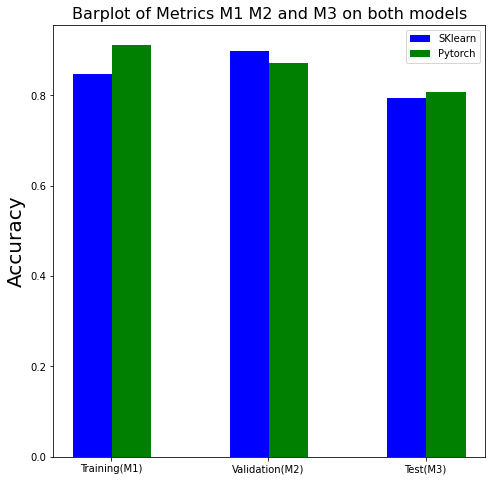

In [8]:
X_points = np.arange(3)
a_data = [M1['b1a'],M2['b1a'],M3['b1a']]
b_data = [M1['b1b'],M2['b1b'],M3['b1b']]
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(X_points, a_data, color = 'b', width = 0.25)
ax.bar(X_points+0.25, b_data, color = 'g', width = 0.25)
ax.set_ylabel('Accuracy',fontsize=20)
ax.set_title("Barplot of Metrics M1 M2 and M3 on both models",fontsize=16)
ax.set_xticks(X_points+0.12)
ax.set_xticklabels(labels=['Training(M1)','Validation(M2)','Test(M3)'])
ax.legend(['SKlearn','Pytorch'],prop={'size': 10})

1. The default lbgs solver/optimizer for the Sklearn logistic regression model wasnt able converge under the default 100 iterations; it took 117. So I expermented with other solvers sag converged after 140 iterations and newton converged after about 47 iterations. Hence in the end I ended up using newton as the solver.
2. Although I am using different solver/optimizers for SKlearn(newton-cg) and pytorch(SGD) implementations the accuracy they both give over train and validation data is significantly different but the they give very similar accuracy over test data.